In [170]:
import numpy as np
import os
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import imageio
import cv2

from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs,expm
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio

import csv
import igraph
from igraph import *

def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    if np.where(rows)[0].size*np.where(cols)[0].size > 0:
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
    else:
        rmin, rmax = 0, 1
        cmin, cmax = 0, 1
    return rmin, rmax, cmin, cmax    

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

import math

def round_up_to_even(f):
    return int(math.ceil(f / 2.) * 2)

def edges_rescaling(edges): # edges are mat.data where mat is a sparse scipy matrix
    edges = np.log10(edges) # log rescale weights because they vary over many decades
    edges -= min(edges) # make them positive 
    edges /= max(edges)*(1.0/10) # rescale from 0 to 10
    return edges

In [171]:
img_id = 164
directory = '/home/garner1/Work/dataset/dataset_patient52/segmented_nuclei_'+str(img_id)

Mwidths = 60
Mheights = 60
images = []
cell_id = []

count = 1
while count <= len(os.listdir(directory)):
    cell = 'iimage_sub'+str(img_id)+'_cell_no_'+str(count)+'.jpg'
    filename = os.path.join(directory, cell)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
    if delta_w >= 0 and delta_h >= 0:
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        newimg = np.pad(img[rmin:rmax,cmin:cmax],((left,right),(top,bottom)),'constant', constant_values=(0))
        images.append(newimg)
        cell_id.append(count)
    else:
        print(filename+' has a problem!')
    count += 1


with open('/home/garner1/Work/dataset/dataset_patient52/centroids_'+str(img_id)+'.txt', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
XY = np.array(properties)[1:,0:2].astype(np.float) # only select x,y coordinates
print('The shape of the geometric data is '+str(XY.shape))

X = np.zeros((len(images),Mwidths*Mheights))
for ind in range(len(images)):
    X[ind,:] = images[ind].flatten() # from 2D arrays to 1D arrays
print('The shape of the morphology data is '+str(X.shape))

'''
Returns
-------
fuzzy_simplicial_set: coo_matrix
A fuzzy simplicial set represented as a sparse matrix. The 
(i,j) entry of the matrix represents the membership strength of the
1-simplex between the ith and jth sample points.
'''
mat_X = umap.umap_.fuzzy_simplicial_set(
    X,
    n_neighbors=50, # this will affect sparsity of the final Hadamard graph
    random_state=np.random.RandomState(seed=42),
    metric='l1',  # use L1 norm to compare morphologies, seems to work better
    metric_kwds={},
    knn_indices=None,
    knn_dists=None,
    angular=False,
    set_op_mix_ratio=1.0,
    local_connectivity=2.0,
    verbose=False
    )

mat_XY = umap.umap_.fuzzy_simplicial_set(
    XY,
    n_neighbors=50, # this will affect sparsity of the final Hadamard graph
    random_state=np.random.RandomState(seed=42),
    metric='l2',
    metric_kwds={},
    knn_indices=None,
    knn_dists=None,
    angular=False,
    set_op_mix_ratio=1.0,
    local_connectivity=2.0,
    verbose=False
    )

hada = mat_X.multiply(mat_XY)
# hada = hada.__pow__(10) # weighted number of length-n paths connecting i to j

hada.data = edges_rescaling(hada.data) # rescale to a log-scale from 0 to 10
# mat_X.data = edges_rescaling(mat_X.data)
# mat_XY.data = edges_rescaling(mat_XY.data)

The shape of the geometric data is (2226, 2)
The shape of the morphology data is (2226, 3600)


Sparsity of the graph is 0.11995779681280368%


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text yticklabel objects>)

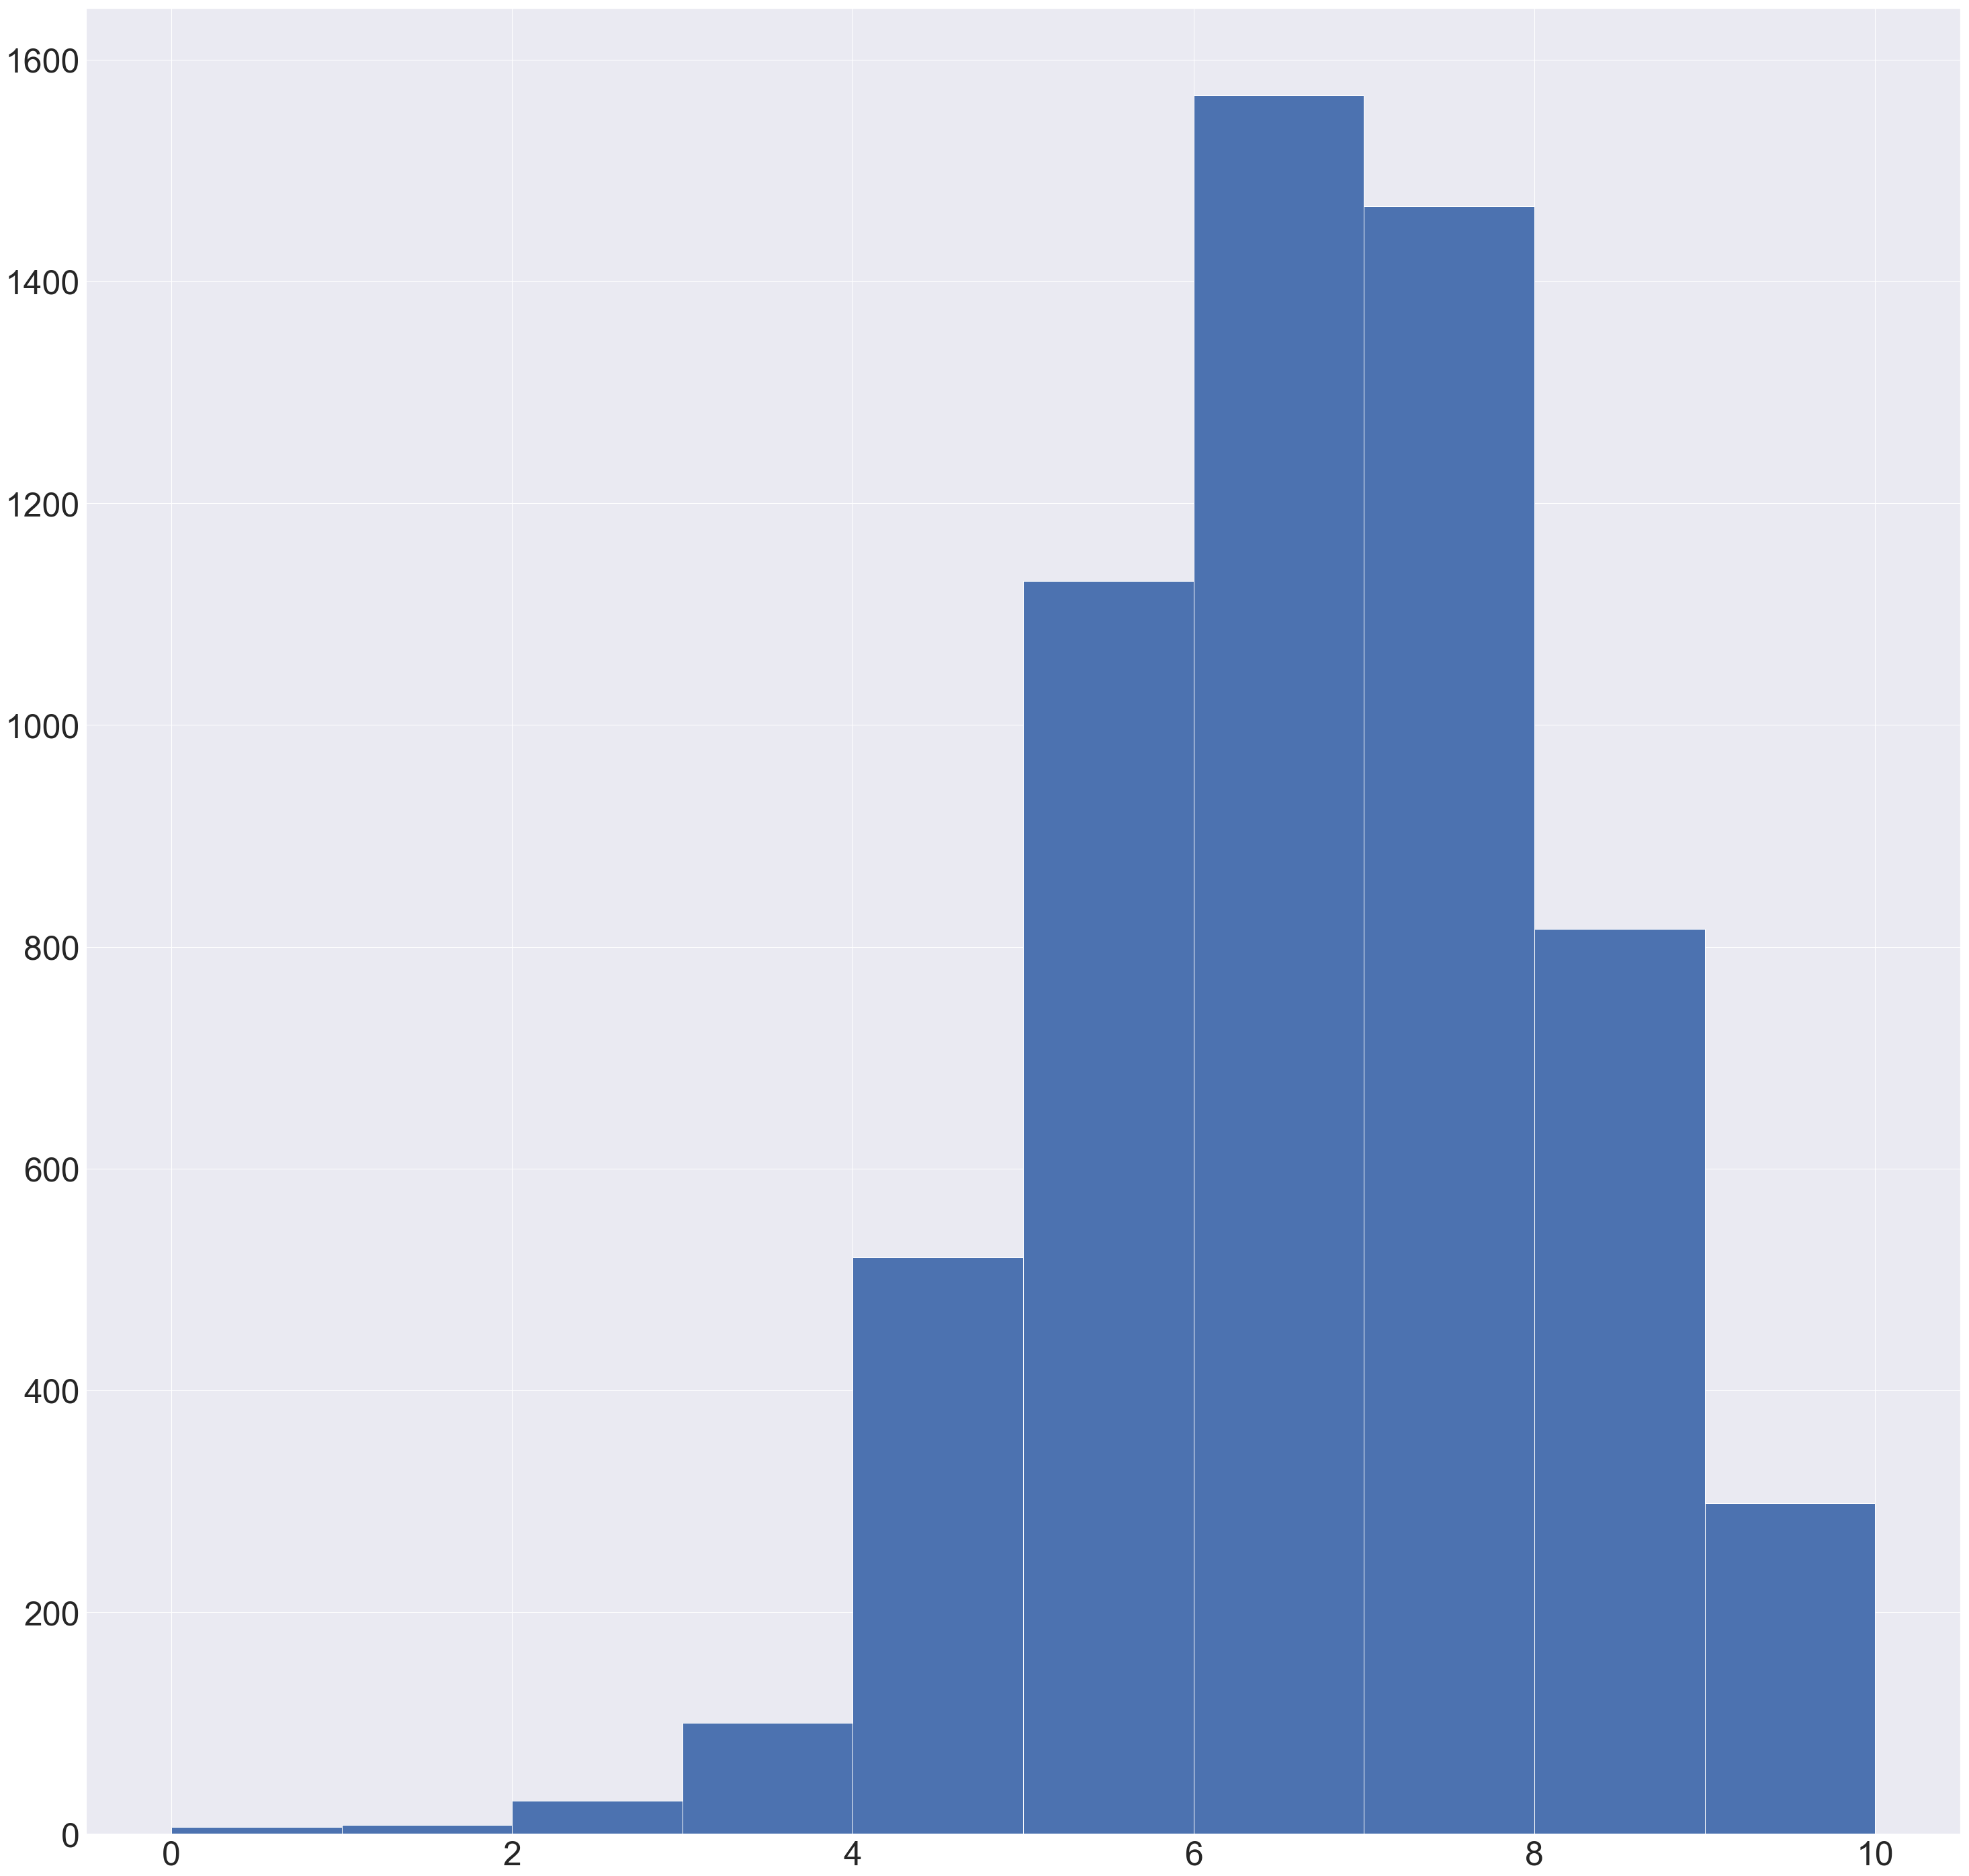

In [172]:
print('Sparsity of the graph is '+str(100*hada.nnz*1.0/hada.shape[0]**2)+'%')

plt.hist(hada.data)
plt.xticks(size = 50)
plt.yticks(size = 50)

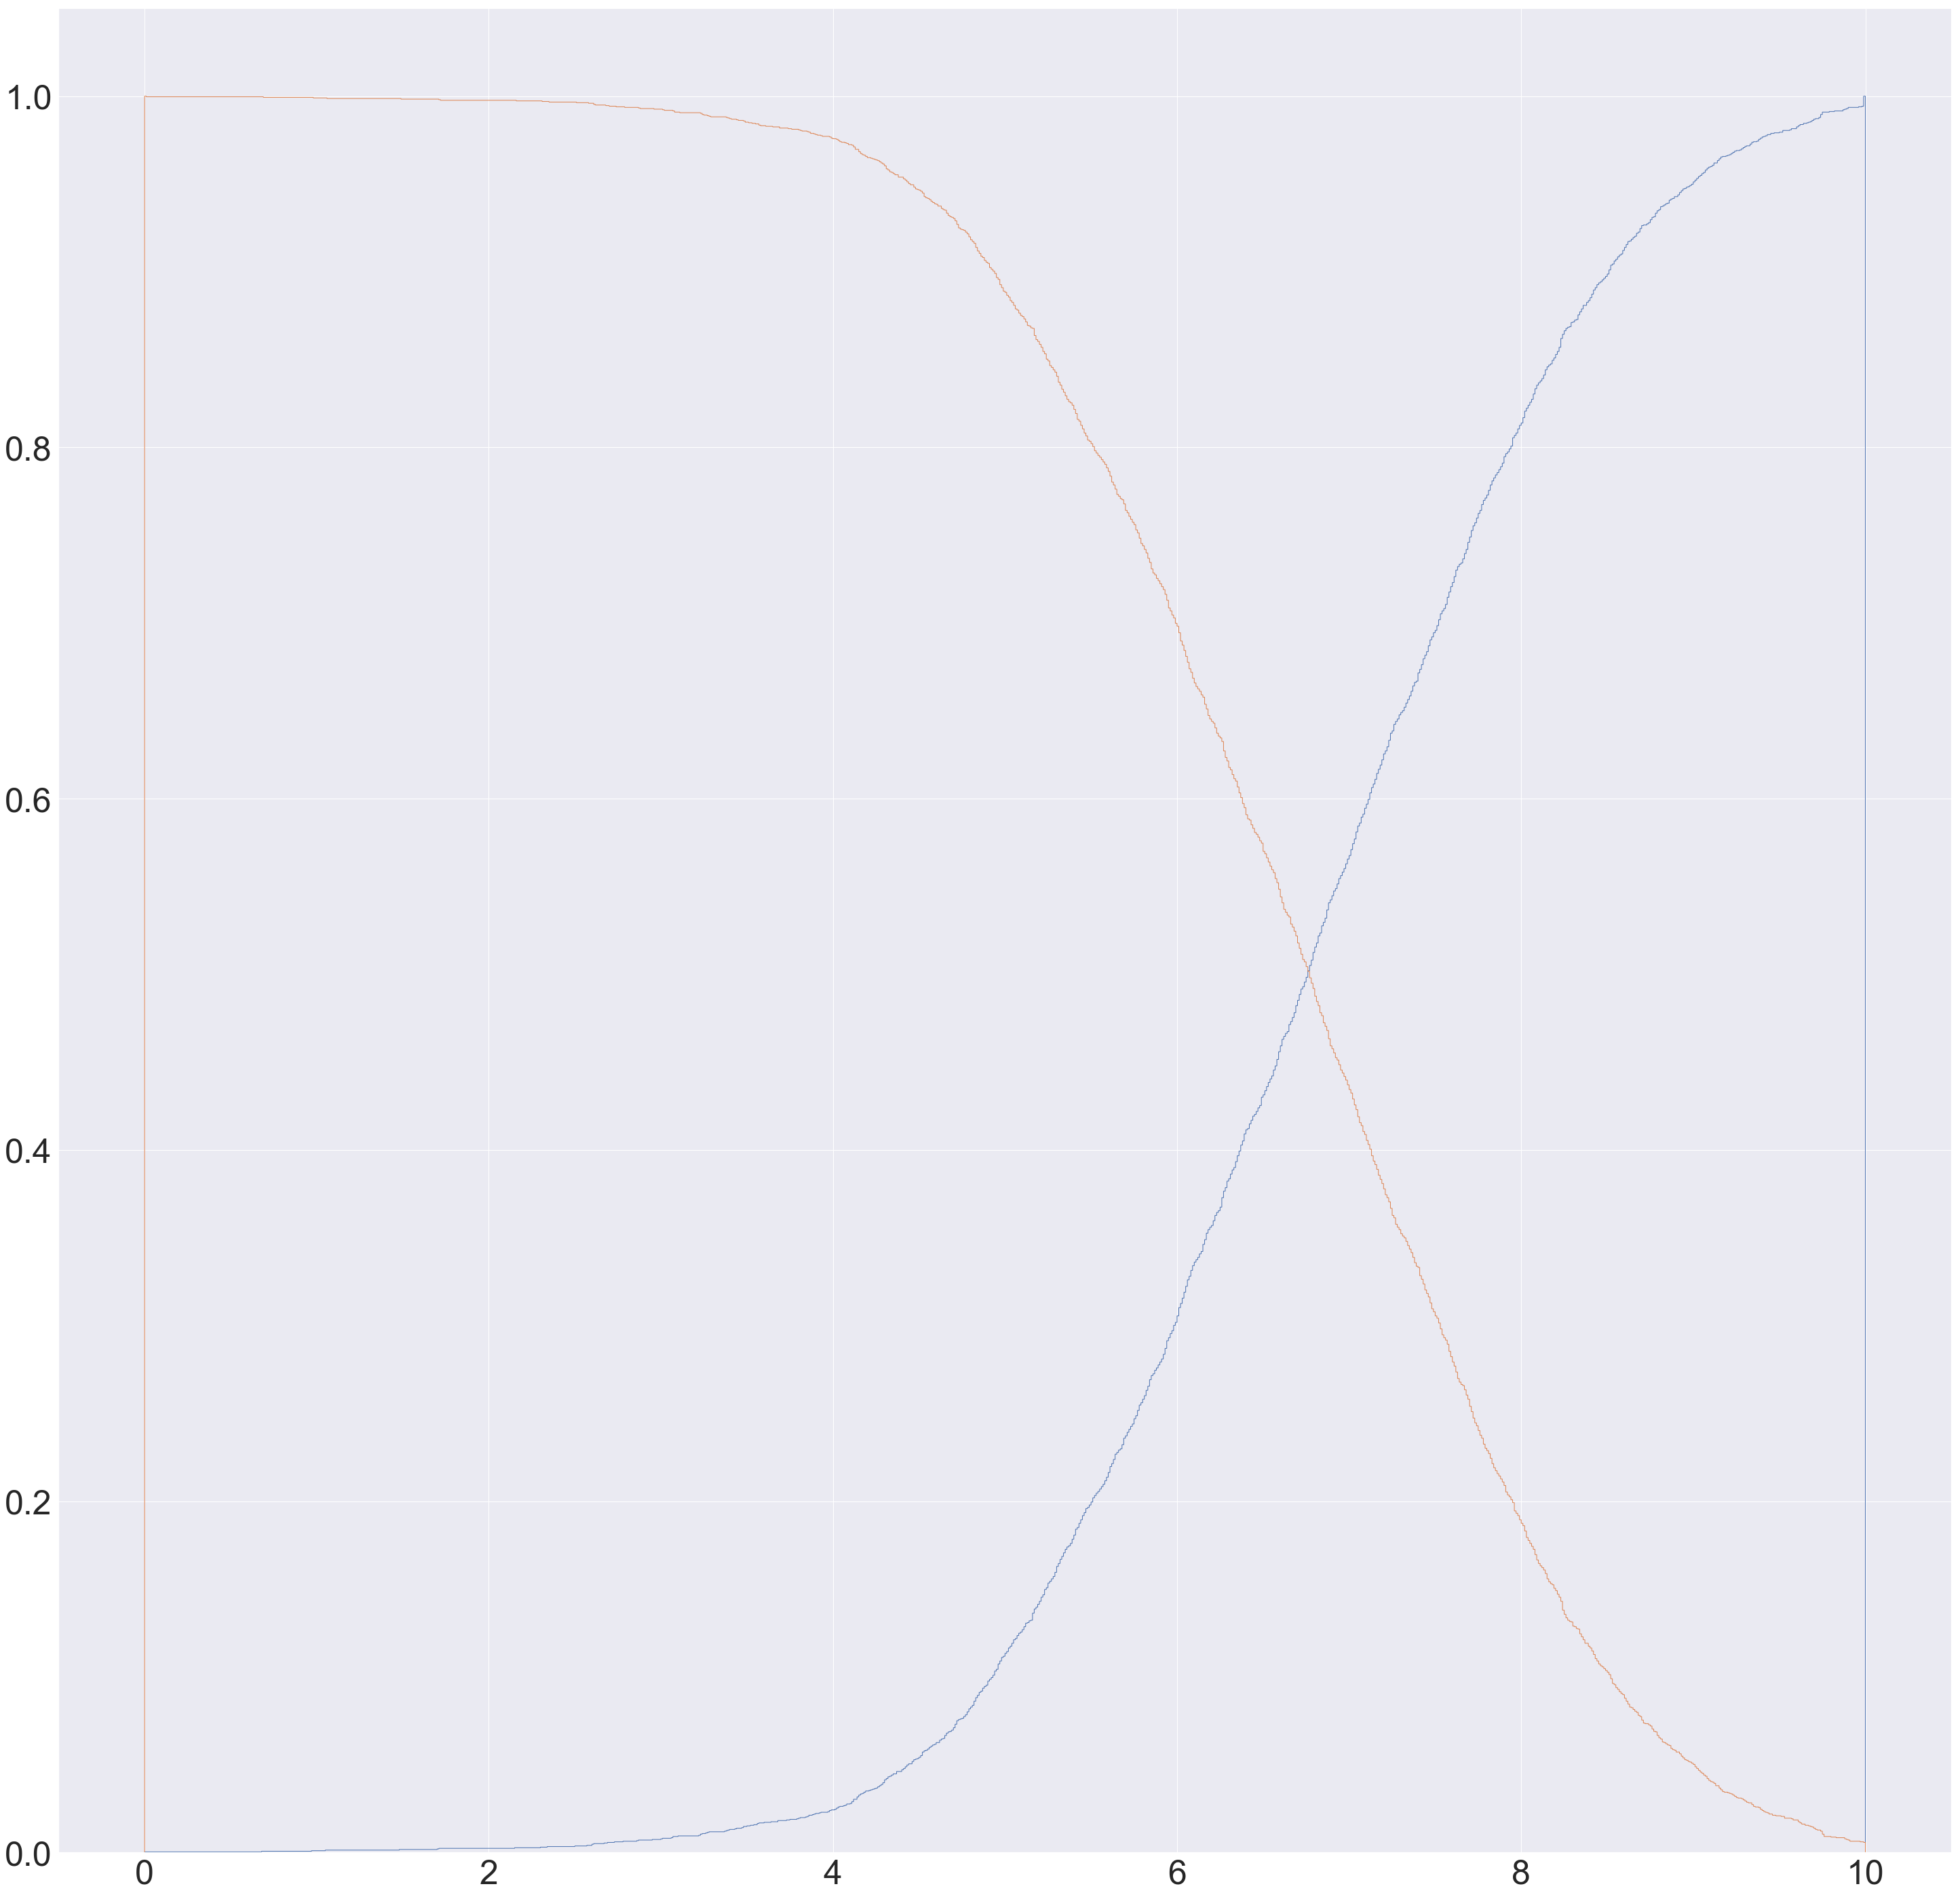

In [181]:
'''
The edges weight are log-gaussian distributed
A log-normal process is the statistical realization 
of the multiplicative product of many independent random variables, each of which is positive
'''
fig, ax = plt.subplots(figsize=(50, 50))
n, bins, patches = ax.hist(hada.data, bins=1000, density=True, histtype='step',cumulative=True)
ax.hist(hada.data, bins=1000, density=True, histtype='step', cumulative=-1,label='Reversed emp.')
plt.xticks(size = 50)
plt.yticks(size = 50)
plt.show()

In [157]:
sns.set(style='white', rc={'figure.figsize':(50,50)})
img = cv2.imread('/home/garner1/Work/dataset/dataset_patient52/iMS266_20190426_001.sub'+str(img_id)+'.jpg', cv2.IMREAD_GRAYSCALE)

G = nx.from_scipy_sparse_matrix(hada) # if sparse matrix

eset = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
pos = XY

# nx.draw_networkx_nodes(G, pos,alpha=0.0)
# nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=0.25, width=weights,edge_color='r',style='solid')
# plt.axis('off')
# plt.imshow(img,cmap='gray')
# plt.savefig(str(img_id)+'graph.png',bbox_inches='tight')
# plt.close()

nx.draw_networkx_nodes(G, pos,alpha=1.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')
plt.savefig(str(img_id)+'graph_only.png',bbox_inches='tight')
plt.close()

# plt.imshow(img,cmap='gray')
# plt.savefig(str(img_id)+'dapi.png',bbox_inches='tight')
# plt.close()

/usr/local/share/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f359dab7950> (for post_execute):


KeyboardInterrupt: 

In [150]:
sources, targets = hada.nonzero()
edgelist = list(zip(sources.tolist(), targets.tolist()))
g = Graph(edgelist,edge_attrs={'weight': hada.data.tolist()})
g = g.simplify(combine_edges=mean)
comm = g.community_fastgreedy(weights=g.es["weight"]) #gives overlapping communities
clust = comm.as_clustering()

big_clusters = [ind for ind in range(len(clust)) if len(clust[ind])>=1] #filter clusters by size
number_of_colors = len(big_clusters)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

sns.set(style='white', rc={'figure.figsize':(50,50)})
count = 0
for i in big_clusters:
    List = [color[count],]*len(clust[i])
    nx.draw_networkx_nodes(G, pos,nodelist=clust[i],alpha=0.9,node_color=List,node_size=1000)
    count += 1
# nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=0.75, width=weights,edge_color='r',style='solid')
plt.axis('off')
plt.imshow(img,cmap='gray')
plt.savefig(str(img_id)+'communities.png',bbox_inches='tight')
plt.close()

The shape of the geometric data is (2226, 2)
The shape of the morphology data is (2226, 3600)


/usr/local/share/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [132]:
# '''
# HDBSCAN clusters in 3D
# low min sample size seems to refuce unclustered data;
# larger min cluster size decrease cluster numbers
# PCA reduction might not be a good idea because shape space is non-linear and the linear reduction could distort distances and later clustering
# '''
# # %time labels = hdbscan.HDBSCAN(min_samples=50,min_cluster_size=100).fit_predict(embedding)

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='w',frameon=False)
# # plt.scatter(embedding[:, 0], embedding[:, 1], s= 1, c=labels, cmap='Spectral')
# plt.scatter(embedding[:, 0], embedding[:, 1], s= 1)
# ##########
# # clustered = (labels >= 0)
# # print('The percentage of clustered data points is '+str(np.sum(clustered) *1.0/ X.shape[0]*100)+'%')


In [38]:
from node2vec import Node2Vec

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=2, walk_length=20, num_walks=200, workers=24)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

%time embedding = np.asarray([model.wv[key] for idx, key in enumerate(model.wv.vocab)])

Computing transition probabilities: 100%|██████████| 1699/1699 [00:03<00:00, 506.46it/s]
